## Project 'Price Prediction' Part I.
#### Выполнен Герасимовой Екатериной( kaygerasimova@gmail.com)

## **Выгрузка библиотек и данных для обработки, создание датафрейма**

In [2]:
#🥦основные:

import numpy as np
import pandas as pd
import pickle
import random

#🥦визуализация:


import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.image as img

#🥦разделение датасета:

from sklearn.model_selection import train_test_split,cross_val_score


#🥦модели:


from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import KFold, GridSearchCV

#🥦метрики:
from sklearn.metrics import r2_score as r2


#🥦дополнительно:
from pylab import rcParams
from __future__ import division, print_function
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)
from scipy import stats
from scipy.stats import mode
import warnings 
warnings.filterwarnings('ignore')

In [3]:
TRAIN_DATASET_PATH = 'Documents/trainPROJECT.csv'
TEST_DATASET_PATH = 'Documents/test (1).csv'
REPORTS_FILE_PATH = 'Documents/reports/'
MODEL_FILE_PATH = 'Documents/models/model.pkl'

In [4]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)

In [5]:
test_df = pd.read_csv(TEST_DATASET_PATH)

In [6]:
def reduce_mem_usage(test_df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = test_df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in test_df.columns:
        col_type = test_df[col].dtype
        
        if col_type != object:
            c_min = test_df[col].min()
            c_max = test_df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    test_df[col] = test_df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    test_df[col] = test_df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    test_df[col] = test_df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    test_df[col] = test_df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    test_df[col] = test_df[col].astype(np.float32)
                else:
                    test_df[col] = test_df[col].astype(np.float64)
        else:
            test_df[col] = test_df[col].astype('category')

    end_mem = test_df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return test_df


In [7]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.72 MB
Memory usage after optimization is: 0.22 MB
Decreased by 70.3%


In [8]:
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


In [9]:
def reduce_mem_usage(train_df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = train_df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in train_df.columns:
        col_type = train_df[col].dtype
        
        if col_type != object:
            c_min = train_df[col].min()
            c_max = train_df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    train_df[col] = train_df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    train_df[col] = train_df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    train_df[col] = train_df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    train_df[col] = train_df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    train_df[col] = train_df[col].astype(np.float32)
                else:
                    train_df[col] = train_df[col].astype(np.float64)
        else:
            train_df[col] = train_df[col].astype('category')

    end_mem = train_df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return train_df

In [10]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


### **первичный обзор тренировочных данных, работа с типами данных**

In [11]:
train_df.shape

(10000, 20)

In [12]:
train_df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

### quantitative variables//оценка через статистическое описание/

In [13]:
train_num_features = train_df.select_dtypes(include=['float64','int64', 'float32', 'int32', 'int8','int16'])
train_num_features

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
0,11809,27,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0,305018.875000
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0,177734.546875
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1,282078.718750
3,2352,1,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1,168106.000000
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6,343995.093750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1260,61,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,52,10311,6,NaN,1,9,119367.453125
9996,16265,27,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,2,629,1,NaN,0,0,199715.156250
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,20,4386,14,NaN,1,5,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,47,8004,3,125.0,3,5,171842.406250


In [14]:
train_num_features = train_num_features.drop(['Price', 'Id', 'DistrictId'],axis=1)
train_num_features

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
0,3.0,115.027313,NaN,10.0,4,10.0,2014,0.075424,11,3097,0,NaN,0,0
1,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,30,6207,1,1183.0,1,0
2,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,33,5261,0,240.0,3,1
3,1.0,40.409908,NaN,1.0,10,22.0,1977,0.007122,1,264,0,NaN,0,1
4,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,33,8667,2,NaN,0,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,2.0,49.090729,33.272625,6.0,3,12.0,1981,0.300323,52,10311,6,NaN,1,9
9996,2.0,64.307686,37.038422,9.0,13,0.0,1977,0.072158,2,629,1,NaN,0,0
9997,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,20,4386,14,NaN,1,5
9998,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,47,8004,3,125.0,3,5


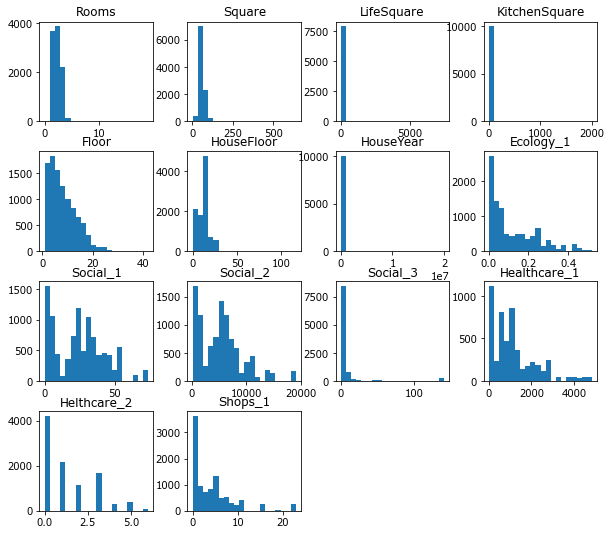

In [15]:
train_num_features.hist(figsize=(10,9), bins=20, grid=False);

In [16]:
train_num_features.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000
mean,1.890500,56.315777,37.199646,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300
std,0.839512,21.058731,86.241211,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517273,1.493601,4.806341
min,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000
50%,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000
75%,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000
max,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000


## Oбработка выбросов

### Rooms

In [17]:
train_df.loc[train_df['Rooms'].isin([0, 6, 10, 19]), 'Rooms'] = train_df['Rooms'].median()

### LifeSquare

In [18]:
train_df.loc[(train_df["LifeSquare"] < 10) , "LifeSquare"] = train_df["LifeSquare"].median()

In [19]:
train_df["LifeSquare"].describe()

count    7887.000000
mean       37.961071
std        86.068954
min        10.523869
25%        23.446383
50%        32.781261
75%        45.128803
max      7480.592285
Name: LifeSquare, dtype: float64

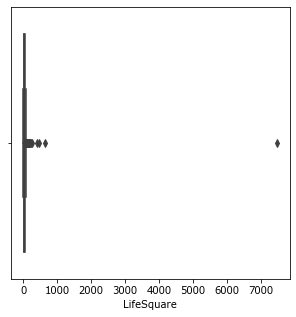

In [20]:
plt.figure(figsize=(5, 5))

sns.boxplot(train_df['LifeSquare'], whis=1.5)

plt.xlabel('LifeSquare')
plt.show()

In [21]:
train_df['LifeSquare'].fillna(train_df["LifeSquare"].median(),inplace=True)

In [22]:
train_df['LifeSquare'].isna()

0       False
1       False
2       False
3       False
4       False
        ...  
9995    False
9996    False
9997    False
9998    False
9999    False
Name: LifeSquare, Length: 10000, dtype: bool

In [23]:
LifeSquare_max_value = np.quantile(train_df['LifeSquare'], q=0.975)
LifeSquare_max_value

78.38594131469725

In [24]:
LifeSquare_mix_value = np.quantile(train_df['LifeSquare'], q=0.25)
LifeSquare_mix_value

27.654812812805176

In [25]:
condition = (train_df['LifeSquare'] > LifeSquare_max_value) | (train_df['LifeSquare'] < LifeSquare_mix_value)
train_df[condition]

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
1,3013,22,1.0,39.832523,23.169222,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.546875
6,8864,44,1.0,33.938751,21.772930,9.0,1,12.0,1968,0.232205,B,B,24,4860,1,80.0,0,3,B,142402.734375
12,898,93,1.0,47.564442,23.574423,13.0,9,24.0,2012,0.050900,B,B,43,10621,1,30.0,2,3,B,199556.859375
13,3526,90,2.0,43.871025,26.114386,5.0,5,9.0,1969,0.265089,B,B,37,5288,0,1937.0,3,2,B,213001.515625
15,4328,96,1.0,36.673409,16.285522,9.0,3,12.0,2003,0.041116,B,B,53,14892,4,NaN,1,4,B,168143.343750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9993,9289,1,3.0,84.486076,88.931511,0.0,4,22.0,2016,0.007122,B,B,1,264,0,NaN,0,1,B,264213.562500
9994,4356,9,1.0,43.303459,21.519087,8.0,12,14.0,1992,0.161532,B,B,25,5648,1,30.0,2,4,B,136744.343750
9997,2795,178,1.0,29.648056,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.906250
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.406250


In [26]:
train_df.loc[condition, 'LifeSquare'] = train_num_features['LifeSquare'].median()
train_df['LifeSquare'].describe()

count    10000.000000
mean        37.279011
std          9.036442
min         27.656244
25%         32.781261
50%         32.781261
75%         39.424684
max         78.384628
Name: LifeSquare, dtype: float64

### Пустые значения Square

In [27]:
SquareBonus = train_df['Square'] - train_df['KitchenSquare']- train_df['LifeSquare']
SquareBonus_df = pd.DataFrame(SquareBonus, columns = ['SquareBonus'])
SquareBonus_df

,SquareBonus
0,72.246048
1,-0.948738
2,20.670246
3,6.628647
4,16.722549
...,...
9995,9.818104
9996,18.269264
9997,-8.133205
9998,-5.450970


In [28]:
df2 = pd.concat([train_df,  SquareBonus_df["SquareBonus"]], axis=1)
df2.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,SquareBonus
0,11809,27,3.0,115.027313,32.781261,10.0,4,10.0,2014,0.075424,...,B,11,3097,0,NaN,0,0,B,305018.875000,72.246048
1,3013,22,1.0,39.832523,32.781261,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,-0.948738
2,8215,1,3.0,78.342216,47.671970,10.0,2,17.0,1988,0.025609,...,B,33,5261,0,240.0,3,1,B,282078.718750,20.670246
3,2352,1,1.0,40.409908,32.781261,1.0,10,22.0,1977,0.007122,...,B,1,264,0,NaN,0,1,B,168106.000000,6.628647
4,13866,94,2.0,64.285065,38.562515,9.0,16,16.0,1972,0.282798,...,B,33,8667,2,NaN,0,6,B,343995.093750,16.722549


In [29]:
df2.loc[ df2["SquareBonus"]  < 0 ]


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,SquareBonus
1,3013,22,1.0,39.832523,32.781261,8.0,7,8.0,1966,0.118537,...,B,30,6207,1,1183.0,1,0,B,177734.546875,-0.948738
6,8864,44,1.0,33.938751,32.781261,9.0,1,12.0,1968,0.232205,...,B,24,4860,1,80.0,0,3,B,142402.734375,-7.842510
15,4328,96,1.0,36.673409,32.781261,9.0,3,12.0,2003,0.041116,...,B,53,14892,4,NaN,1,4,B,168143.343750,-5.107853
23,13427,103,1.0,38.174328,32.781261,9.0,6,12.0,1969,0.014423,...,B,19,3806,4,NaN,0,3,B,194273.046875,-3.606934
28,1924,24,1.0,34.127060,32.781261,6.0,5,5.0,1960,0.111627,...,B,50,12238,8,1970.0,2,3,B,173155.765625,-4.654202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9988,1621,9,1.0,39.630081,32.781261,8.0,8,14.0,1990,0.161532,...,B,25,5648,1,30.0,2,4,B,127641.210938,-1.151180
9990,10635,21,1.0,18.983963,32.781261,2.0,1,5.0,1967,0.194489,...,B,47,8004,3,125.0,3,5,B,112411.218750,-15.797298
9997,2795,178,1.0,29.648056,32.781261,5.0,3,5.0,1958,0.460556,...,B,20,4386,14,NaN,1,5,B,165953.906250,-8.133205
9998,14561,21,1.0,32.330292,32.781261,5.0,3,9.0,1969,0.194489,...,B,47,8004,3,125.0,3,5,B,171842.406250,-5.450970


In [30]:
df2.loc[df2["SquareBonus"] < 0, "Square"] =  df2['KitchenSquare'] + df2['LifeSquare']

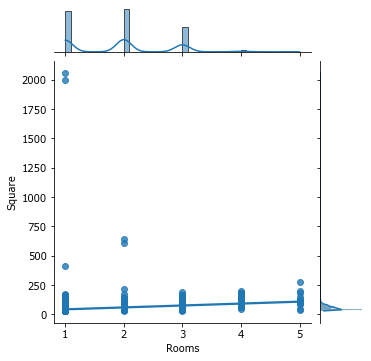

In [31]:
grid = sns.jointplot(df2['Rooms'], df2['Square'], kind='reg')
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)

plt.show()

In [32]:
df2.iloc[:,[3,4,5]]

,Square,LifeSquare,KitchenSquare
0,115.027313,32.781261,10.0
1,40.781261,32.781261,8.0
2,78.342216,47.671970,10.0
3,40.409908,32.781261,1.0
4,64.285065,38.562515,9.0
...,...,...,...
9995,49.090729,33.272625,6.0
9996,64.307686,37.038422,9.0
9997,37.781261,32.781261,5.0
9998,37.781261,32.781261,5.0


### Замена выбросов в значениях Square 

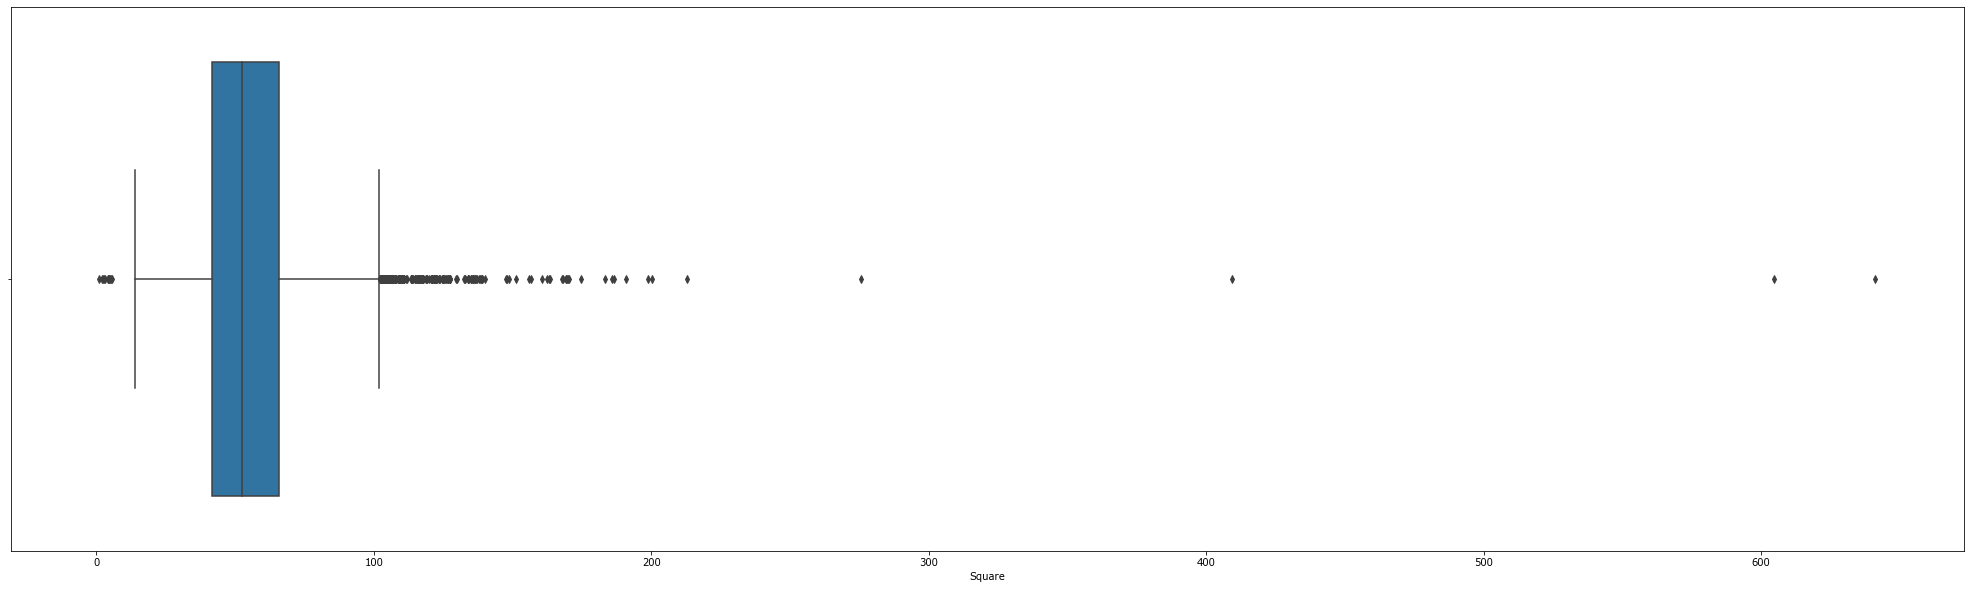

In [33]:
plt.figure(figsize=(35, 10))

sns.boxplot(train_num_features['Square'], whis=1.5)

plt.xlabel('Square')
plt.show()

In [34]:
df2.loc[df2['Square'] > df2['Square'].quantile(.975), 'Square']  = df2['Square'].median()

In [35]:
df2.loc[df2['Square'] < df2['Square'].quantile(.025), 'Square']  = df2['Square'].median()

In [36]:
df2.iloc[:,[3,4,5]]

,Square,LifeSquare,KitchenSquare
0,52.969044,32.781261,10.0
1,40.781261,32.781261,8.0
2,78.342216,47.671970,10.0
3,40.409908,32.781261,1.0
4,64.285065,38.562515,9.0
...,...,...,...
9995,49.090729,33.272625,6.0
9996,64.307686,37.038422,9.0
9997,37.781261,32.781261,5.0
9998,37.781261,32.781261,5.0


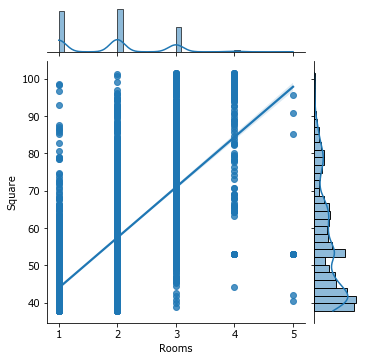

In [37]:
grid = sns.jointplot(df2['Rooms'], df2['Square'], kind='reg')
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)

plt.show()

In [38]:

df2.loc[(df2["Rooms"] == 5) & (df2['Square'] < 50), "Square"] =  50

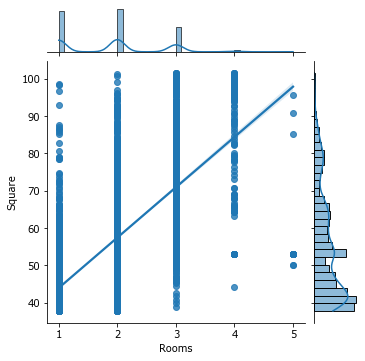

In [39]:
grid = sns.jointplot(df2['Rooms'], df2['Square'], kind='reg')
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)

plt.show()

### Floor vs. HouseFloor


In [40]:
train_df = df2.drop('SquareBonus',axis=1)

In [41]:
col_mapping = [f"{c[0]}:{c[1]}" for c in enumerate(train_df.columns)]
col_mapping

['0:Id',
 '1:DistrictId',
 '2:Rooms',
 '3:Square',
 '4:LifeSquare',
 '5:KitchenSquare',
 '6:Floor',
 '7:HouseFloor',
 '8:HouseYear',
 '9:Ecology_1',
 '10:Ecology_2',
 '11:Ecology_3',
 '12:Social_1',
 '13:Social_2',
 '14:Social_3',
 '15:Healthcare_1',
 '16:Helthcare_2',
 '17:Shops_1',
 '18:Shops_2',
 '19:Price']

In [42]:
train_df["Floor"].describe()

count    10000.000000
mean         8.526700
std          5.241148
min          1.000000
25%          4.000000
50%          7.000000
75%         12.000000
max         42.000000
Name: Floor, dtype: float64

In [43]:
train_df['Floor'].sort_values().unique()


array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

In [44]:
train_df.loc[train_df['HouseFloor'].isin([0, 99, 117]), 'HouseFloor'] = train_df['HouseFloor'].median()

In [45]:
train_df['HouseFloor'].astype(int)

0       10
1        8
2       17
3       22
4       16
        ..
9995    12
9996    13
9997     5
9998     9
9999     9
Name: HouseFloor, Length: 10000, dtype: int32

In [46]:
train_df['HouseFloor'].sort_values().unique()

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 36., 37., 38., 39., 40., 44., 45.,
       47., 48.], dtype=float32)

In [47]:
# необходимо избавиться от несоответствия этажа и этажности

In [48]:
floor_outliers = train_df['Floor'] > train_df['HouseFloor']
floor_outliers.sum()

1610

In [49]:
train_df.loc[train_df['Floor'] > train_df['HouseFloor'], 'Floor'] = 1

In [50]:
floor_outliers = train_df['Floor'] > train_df['HouseFloor']
floor_outliers.sum()

0

In [51]:
# f = train_df["Floor"]
# f.index = train_df["HouseFloor"]

# f.plot(kind="barh")

# plt.show()


In [52]:


# rcParams["figure.figsize"] = 15, 25

In [53]:

# f.index = f.index.sort_values()
# f.plot(kind="barh")



# plt.show()

In [54]:
train_df["Floor"].describe()

count    10000.000000
mean         6.880200
std          5.220476
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         42.000000
Name: Floor, dtype: float64

### data fixing & new variables

In [55]:
train_df['HouseYear'].sort_values().unique()

array([    1910,     1912,     1914,     1916,     1917,     1918,
           1919,     1928,     1929,     1930,     1931,     1932,
           1933,     1934,     1935,     1936,     1937,     1938,
           1939,     1940,     1941,     1942,     1947,     1948,
           1950,     1951,     1952,     1953,     1954,     1955,
           1956,     1957,     1958,     1959,     1960,     1961,
           1962,     1963,     1964,     1965,     1966,     1967,
           1968,     1969,     1970,     1971,     1972,     1973,
           1974,     1975,     1976,     1977,     1978,     1979,
           1980,     1981,     1982,     1983,     1984,     1985,
           1986,     1987,     1988,     1989,     1990,     1991,
           1992,     1993,     1994,     1995,     1996,     1997,
           1998,     1999,     2000,     2001,     2002,     2003,
           2004,     2005,     2006,     2007,     2008,     2009,
           2010,     2011,     2012,     2013,     2014,     2

In [56]:
train_df.loc[train_df['HouseYear'].isin([4968]), 'HouseYear'] = 1968

In [57]:
train_df.loc[train_df['HouseYear'].isin([200520011]), 'HouseYear'] = 2011

In [58]:
# добавить новую апеременную 'age_bins'

In [59]:
train_df['med_house_year'] = (2022 - train_df['HouseYear'])
train_df['med_house_year'] 

0        8
1       56
2       34
3       45
4       50
        ..
9995    41
9996    45
9997    64
9998    53
9999    47
Name: med_house_year, Length: 10000, dtype: int32

In [60]:
def age_to_binary_cat(X):

    X['age_binary_cat'] = 0
    X.loc[X['HouseYear'] <= 5, 'age_binary_cat'] = 1  

    return X

In [61]:
train_df = age_to_binary_cat(train_df)


### Helthcare - обработка пропусков

In [62]:
train_df['Healthcare_1'].sort_values().unique()

array([   0.,   30.,   32.,   35.,   46.,   75.,   80.,  100.,  125.,
        145.,  165.,  176.,  192.,  200.,  229.,  240.,  262.,  320.,
        325.,  350.,  370.,  520.,  540.,  562.,  620.,  628.,  645.,
        705.,  730.,  750.,  770.,  800.,  810.,  830.,  900.,  920.,
        990., 1015., 1020., 1036., 1046., 1084., 1130., 1145., 1183.,
       1308., 1322., 1340., 1406., 1430., 1450., 1547., 1548., 1575.,
       1786., 1815., 1894., 1937., 1940., 1970., 1994., 2078., 2300.,
       2301., 2500., 2620., 2643., 2672., 2715., 2729., 2857., 2890.,
       3300., 3855., 4087., 4129., 4508., 4702., 4849.,   nan],
      dtype=float32)

In [63]:
train_df.loc[df2['Healthcare_1'].isnull(), 'Healthcare_1'] = train_df['Healthcare_1'].median()

# категориальные данные

In [64]:

big_data =train_df.copy()

numeric_subset = train_df.drop(['Shops_2', 'Ecology_2', 'Ecology_3'], axis=1)
categorical_subset = train_df[['Shops_2', 'Ecology_2', 'Ecology_3']]
categorical_subset = pd.get_dummies(categorical_subset)

data_train = pd.concat([numeric_subset, categorical_subset], axis = 1)

In [65]:
data_train.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Price             float32
med_house_year      int32
age_binary_cat      int64
Shops_2_A           uint8
Shops_2_B           uint8
Ecology_2_A         uint8
Ecology_2_B         uint8
Ecology_3_A         uint8
Ecology_3_B         uint8
dtype: object

In [66]:
data_train[data_train.isna()].sum()

Id                0.0
DistrictId        0.0
Rooms             0.0
Square            0.0
LifeSquare        0.0
KitchenSquare     0.0
Floor             0.0
HouseFloor        0.0
HouseYear         0.0
Ecology_1         0.0
Social_1          0.0
Social_2          0.0
Social_3          0.0
Healthcare_1      0.0
Helthcare_2       0.0
Shops_1           0.0
Price             0.0
med_house_year    0.0
age_binary_cat    0.0
Shops_2_A         0.0
Shops_2_B         0.0
Ecology_2_A       0.0
Ecology_2_B       0.0
Ecology_3_A       0.0
Ecology_3_B       0.0
dtype: float64

In [67]:
data_train[data_train.isnull()].sum()

Id                0.0
DistrictId        0.0
Rooms             0.0
Square            0.0
LifeSquare        0.0
KitchenSquare     0.0
Floor             0.0
HouseFloor        0.0
HouseYear         0.0
Ecology_1         0.0
Social_1          0.0
Social_2          0.0
Social_3          0.0
Healthcare_1      0.0
Helthcare_2       0.0
Shops_1           0.0
Price             0.0
med_house_year    0.0
age_binary_cat    0.0
Shops_2_A         0.0
Shops_2_B         0.0
Ecology_2_A       0.0
Ecology_2_B       0.0
Ecology_3_A       0.0
Ecology_3_B       0.0
dtype: float64

# EDA

## Target_analysis 

Text(0.5, 1.0, ' Price Distribution')

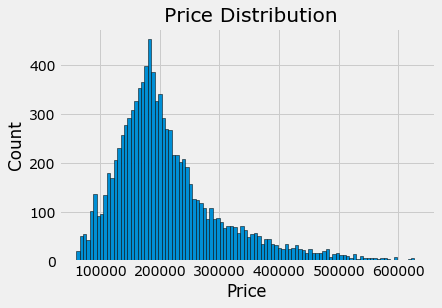

In [68]:
plt.style.use('fivethirtyeight')
plt.hist(data_train['Price'].dropna(), bins = 100, edgecolor = 'k')
plt.xlabel('Price') 
plt.ylabel('Count') 
plt.title(' Price Distribution')

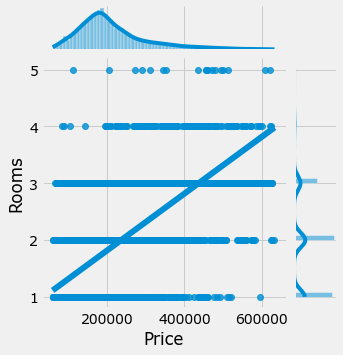

In [72]:
grid = sns.jointplot(data_train['Price'], data_train['Rooms'], kind='reg')
grid.fig.set_figwidth(5)
grid.fig.set_figheight(5)

plt.show()

# matrix cor

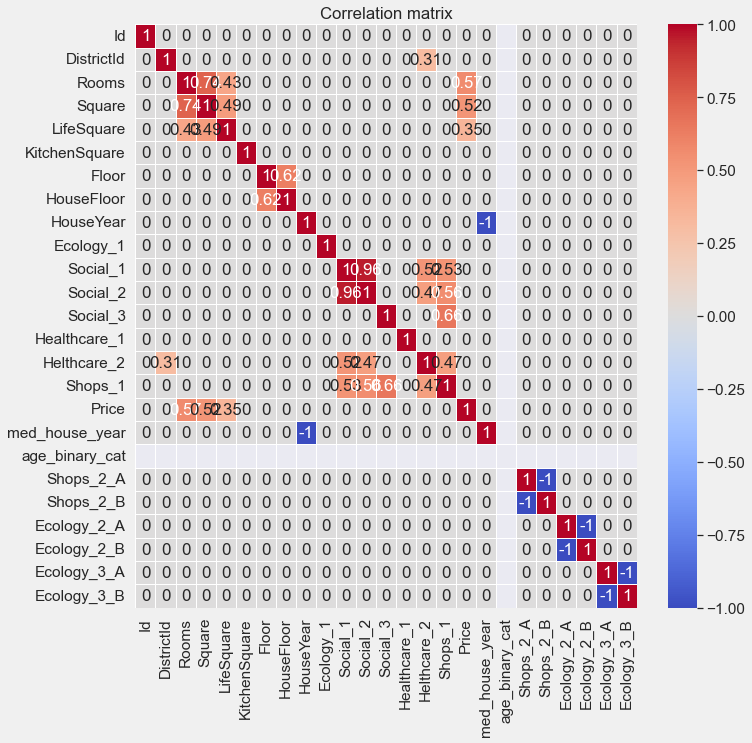

In [73]:
plt.figure(figsize = (10,10))

sns.set(font_scale=1.4)

corr_matrix = data_train.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0

sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

plt.title('Correlation matrix')
plt.show()

## Отбор признаков

In [74]:
data_train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Price',
 'med_house_year',
 'age_binary_cat',
 'Shops_2_A',
 'Shops_2_B',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B']

In [77]:
features = {"f1":u"'DistrictId'",
"f2":u"Rooms",
"f3":u"Square",
"f4":u"LifeSquare",
"f5":u"KitchenSquare",
"f6":u"Floor",
"f7":u"HouseFloor",
"f8":u"HouseYear",
"f9":u"Ecology_1",
"f10":u"Social_1",
"f11":u"Social_2",
"f12":u"Social_3",
"f13":u"Healthcare_1",
"f14":u"Healthcare_2",
"f15":u"Shops_1",
"f16":u"med_house_year",
"f18":u"age_binary_cat",  
"f19":u"Shops_2_A",
"f20":u"Shops_2_B",
"f21":u"Ecology_2_A",
"f22":u"Ecology_2_B",
"f23":u"Ecology_3_A",
"f24":u"Ecology_3_B"
 }

target_name = 'Price'

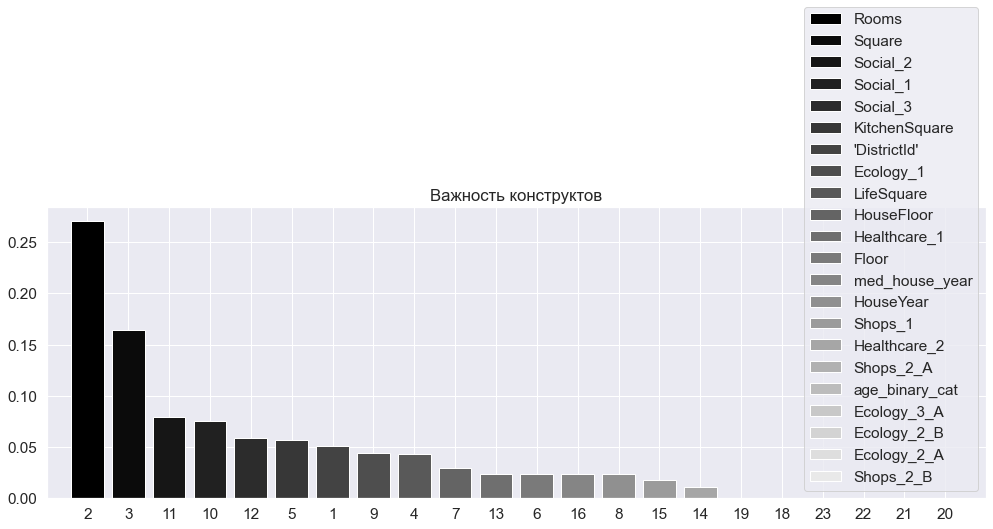

In [78]:
data_t = data_train.copy()
forest = RandomForestRegressor(n_estimators=1000, max_features=25,
                                random_state=42)

forest.fit(data_t.drop(['Id', 'Price'], axis=1), 
           data_t['Price'])
importances = forest.feature_importances_

indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 22
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# # Print the feature ranking
# print("Feature ranking:")

# for f in range(num_to_plot):
#     print("%d. %s %f " % (f + 1, 
#             data_train["f"+str(feature_indices[f])], 
#             importances[indices[f]]))
plt.figure(figsize=(15,5))
plt.title(u"Важность конструктов")
bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
       color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
ticks = plt.xticks(range(num_to_plot), 
                   feature_indices)
plt.xlim([-1, num_to_plot])
plt.legend(bars, [u''.join(features["f"+str(i)]) 
                  for i in feature_indices]);
plt.show()

In [80]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Id              10000 non-null  int16  
 1   DistrictId      10000 non-null  int16  
 2   Rooms           10000 non-null  float32
 3   Square          10000 non-null  float32
 4   LifeSquare      10000 non-null  float32
 5   KitchenSquare   10000 non-null  float32
 6   Floor           10000 non-null  int8   
 7   HouseFloor      10000 non-null  float32
 8   HouseYear       10000 non-null  int32  
 9   Ecology_1       10000 non-null  float32
 10  Social_1        10000 non-null  int8   
 11  Social_2        10000 non-null  int16  
 12  Social_3        10000 non-null  int16  
 13  Healthcare_1    10000 non-null  float32
 14  Helthcare_2     10000 non-null  int8   
 15  Shops_1         10000 non-null  int8   
 16  Price           10000 non-null  float32
 17  med_house_year  10000 non-null  

# test!!! preprocessing

In [81]:
# test_df = pd.read_csv(TEST_DATASET_PATH)

In [82]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             5000 non-null   int16   
 1   DistrictId     5000 non-null   int16   
 2   Rooms          5000 non-null   float32 
 3   Square         5000 non-null   float32 
 4   LifeSquare     3959 non-null   float32 
 5   KitchenSquare  5000 non-null   float32 
 6   Floor          5000 non-null   int8    
 7   HouseFloor     5000 non-null   float32 
 8   HouseYear      5000 non-null   int16   
 9   Ecology_1      5000 non-null   float32 
 10  Ecology_2      5000 non-null   category
 11  Ecology_3      5000 non-null   category
 12  Social_1       5000 non-null   int8    
 13  Social_2       5000 non-null   int16   
 14  Social_3       5000 non-null   int16   
 15  Healthcare_1   2623 non-null   float32 
 16  Helthcare_2    5000 non-null   int8    
 17  Shops_1        5000 non-null   in

In [83]:
test_df.shape

(5000, 19)

In [84]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449501,36.158806,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657227,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744263,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906230,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921339,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285130,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453690,303.071106,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


### data fixing & new variables



In [85]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        self.medians = None
        self.mode = None
        
        
    def fit(self, test_df):
        """Сохранение статистик"""
        
        # Расчет медиан
        self.medians = test_df[['LifeSquare', 'Rooms', 'Healthcare_1','KitchenSquare']].median()
        
                   
        
    def transform(self, test_df):
        test_df['HouseFloor'].astype(int)
        test_df['Floor'].astype(int)
        
        """Трансформация данных"""
        
        # 1. Пропуски
        test_df['LifeSquare'] = test_df['LifeSquare'].fillna(10)
            
        test_df['Healthcare_1'] = test_df['Healthcare_1'].fillna(10)
        
        # 2. Выбросы (outliers)
       
        test_df.loc[test_df['Rooms'].isin([0, 5, 6, 17]), 'Rooms'] =  test_df['Rooms'].median()
        test_df.loc[(test_df["LifeSquare"] < 10) , 'LifeSquare'] = 10
        test_df.loc[(test_df['KitchenSquare'] > test_df['KitchenSquare'].quantile(.975)) | (test_df['KitchenSquare'] < test_df['KitchenSquare'].quantile(.025)) , 'KitchenSquare'] = test_df['KitchenSquare'].median()
        test_df.loc[(test_df['LifeSquare'] > test_df['LifeSquare'].quantile(.975)) | (test_df['LifeSquare'] < test_df['LifeSquare'].quantile(.025)) , 'LifeSquare'] = test_df['LifeSquare'].median()
        test_df.loc[(test_df['Square'] - test_df['KitchenSquare']- test_df['LifeSquare']) < 0, "Square"] =  test_df['KitchenSquare'] + test_df['LifeSquare']
        test_df.loc[test_df['Square'] > test_df['Square'].quantile(.975), 'Square']  = test_df['Square'].median()
        test_df.loc[test_df['Square'] < test_df['Square'].quantile(.025), 'Square']  = test_df['Square'].median()
        test_df.loc[test_df['Floor'] > test_df['HouseFloor'], 'Floor'] = 1 
        test_df.loc[(test_df["Rooms"] == 5) & (test_df['Square'] < 50), "Square"] =  50
        
       
        
        # 4. Обработка категорий
        


        numeric_subset = test_df.drop(['Shops_2', 'Ecology_2', 'Ecology_3'], axis=1)
        categorical_subset = test_df[['Shops_2', 'Ecology_2', 'Ecology_3']]
        categorical_subset = pd.get_dummies(categorical_subset)
        test_df = pd.concat([numeric_subset, categorical_subset], axis = 1)
           
        

        
        
        return test_df



In [86]:
pipe = DataPipeline()
pipe.fit(test_df)
test_df = pipe.transform(test_df)

In [87]:
test_df['med_house_year'] = (2022 - test_df['HouseYear'])
test_df['med_house_year'] 

0       52
1        5
2       45
3       57
4       45
        ..
4995    60
4996     4
4997    56
4998    52
4999    13
Name: med_house_year, Length: 5000, dtype: int16

In [88]:
def age_to_binary_cat(X):

    X['age_binary_cat'] = 0
    X.loc[X['med_house_year'] <= 5, 'age_binary_cat'] = 1 
            
    return X

test_df = age_to_binary_cat(test_df)

In [89]:
test_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2_A,Shops_2_B,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,med_house_year,age_binary_cat
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,...,5000.00000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,8412.595400,51.279200,1.902000,55.796295,29.256016,5.530200,6.854400,12.601000,1984.392600,0.119874,...,1.31940,4.242800,0.082400,0.917600,0.009600,0.990400,0.029800,0.970200,37.607400,0.050200
std,4832.674037,44.179466,0.797573,15.294789,15.580914,3.589772,5.369522,6.789213,18.573149,0.120070,...,1.47994,4.777365,0.275001,0.275001,0.097518,0.097518,0.170052,0.170052,18.573149,0.218379
min,1.000000,0.000000,1.000000,32.354992,10.000000,0.000000,1.000000,0.000000,1908.000000,0.000000,...,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000
25%,4221.750000,21.000000,1.000000,42.952868,17.873732,1.000000,3.000000,9.000000,1973.000000,0.019509,...,0.00000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,22.000000,0.000000
50%,8320.500000,37.000000,2.000000,53.373903,29.118665,6.000000,5.000000,12.000000,1977.000000,0.072158,...,1.00000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,45.000000,0.000000
75%,12598.250000,77.000000,2.000000,65.650080,39.660613,8.000000,10.000000,17.000000,2000.000000,0.195781,...,2.00000,6.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,49.000000,0.000000
max,16795.000000,212.000000,4.000000,100.729996,77.532036,12.000000,46.000000,99.000000,2020.000000,0.521867,...,6.00000,23.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,114.000000,1.000000



### сохранение данных

In [90]:
test_df[test_df.isnull()].sum()

Id                0.0
DistrictId        0.0
Rooms             0.0
Square            0.0
LifeSquare        0.0
KitchenSquare     0.0
Floor             0.0
HouseFloor        0.0
HouseYear         0.0
Ecology_1         0.0
Social_1          0.0
Social_2          0.0
Social_3          0.0
Healthcare_1      0.0
Helthcare_2       0.0
Shops_1           0.0
Shops_2_A         0.0
Shops_2_B         0.0
Ecology_2_A       0.0
Ecology_2_B       0.0
Ecology_3_A       0.0
Ecology_3_B       0.0
med_house_year    0.0
age_binary_cat    0.0
dtype: float64

In [91]:
test_df[test_df.isna()].sum()

Id                0.0
DistrictId        0.0
Rooms             0.0
Square            0.0
LifeSquare        0.0
KitchenSquare     0.0
Floor             0.0
HouseFloor        0.0
HouseYear         0.0
Ecology_1         0.0
Social_1          0.0
Social_2          0.0
Social_3          0.0
Healthcare_1      0.0
Helthcare_2       0.0
Shops_1           0.0
Shops_2_A         0.0
Shops_2_B         0.0
Ecology_2_A       0.0
Ecology_2_B       0.0
Ecology_3_A       0.0
Ecology_3_B       0.0
med_house_year    0.0
age_binary_cat    0.0
dtype: float64

In [92]:
data_train.to_csv("data_train.csv", sep=";", index=False)

In [93]:
test_df.to_csv("test.csv", sep=";", index=False)

In [94]:
test_df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2_A,Shops_2_B,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,med_house_year,age_binary_cat
0,4567,44,1.0,36.847630,19.094183,5.0,5,9.0,1970,0.036122,...,1,1,0,1,0,1,0,1,52,0
1,5925,62,1.0,52.568134,42.568134,10.0,7,17.0,2017,0.072158,...,0,0,1,0,0,1,0,1,5,1
2,960,27,2.0,59.463676,10.000000,9.0,19,19.0,1977,0.211401,...,0,1,0,1,0,1,0,1,45,0
3,3848,23,3.0,49.646030,33.893826,6.0,2,2.0,1965,0.014073,...,0,0,0,1,0,1,0,1,57,0
4,746,74,1.0,53.837055,10.000000,1.0,8,17.0,1977,0.309479,...,0,6,0,1,0,1,0,1,45,0
